*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.10.2024

--- 

# Uncertainty of the traffic volume estimate

<!--Notebook description and usage information-->
TBD


In [1]:
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from math import sqrt

import seaborn as sns


# import custom modules
sys.path.append('../../utils')
import data_paths
import traffic_counts
import excel_calendar

# Notebook Settings 

In [2]:
# define filename of the visum file
visum_filename = "visum_links.GPKG"
cnt_data_filename = data_paths.COUNTING_PATH + 'counting_data_combined.parquet'

## Import Data

In [3]:
# import visum model
_tm = gpd.read_file(data_paths.VISUM_FOLDER_PATH + visum_filename)
_tm['dtv_PC'] = _tm['dtv_SUM'] * _tm['delta_PC']
_tm['dtv_LCV'] = _tm['dtv_SUM'] * _tm['delta_LCV']
_tm['dtv_HGV'] = _tm['dtv_SUM'] * _tm['delta_HGV']
traffic_model = _tm.groupby('road_link_id').agg({'dtv_SUM': 'sum',
                                                 'dtv_PC': 'sum',
                                                 'dtv_LCV': 'sum',
                                                 'dtv_HGV': 'sum',
                                                 'scaling_road_type': lambda group: group.iloc[0]})

# import counting data
cnt_data = pd.read_parquet(cnt_data_filename)
cnt_data = cnt_data[cnt_data['date'].between('2019-01-01', '2019-12-31')]

# notebook variables
valid_road_links = cnt_data[(cnt_data['valid'])]['road_link_id'].unique()
vehicle_classes = ['PC', 'HGV', 'LCV', 'MOT', 'BUS', 'SUM']

In [4]:
# initialize objects
traffic_activity = traffic_counts.TrafficCounts()
cal = excel_calendar.Calendar()

## Notebook Functions

In [5]:
def Serialize_cnt(df):
    cnt_ser = pd.DataFrame()
    for idx, row in df.iterrows():
        _df = pd.DataFrame(index=pd.date_range(start=idx,
                                               periods = 24,
                                               freq='1h'),
                        data = {'count': np.array(row[-24:])})
        cnt_ser = pd.concat([cnt_ser, _df])
    cnt_ser = cnt_ser.sort_index()
    return cnt_ser

In [6]:
def divide_no_error(a,b): 
    try:
        return a/b
    except ZeroDivisionError:
        return np.nan
    
def calc_sqv(Observed, Model, f=1000):
    if (Model == 0) or (Observed == 0):
        return 0
    if Model == Observed:
        return 1
    # f = 10000 is the recommended factor for daily volumes
    denominator = 1 + sqrt((pow(Model - Observed, 2)/(f * Observed)))
    return divide_no_error(1, denominator)

## Processing and Plotting

In [7]:
cnt_grp = cnt_data.set_index('date').groupby(['road_link_id', 'vehicle_class'])
serialized_counts = dict()

for idx, grp in cnt_grp:
    _cnt_ser = Serialize_cnt(grp)
    serialized_counts.update({idx:_cnt_ser})

for id in valid_road_links:
    road_type = traffic_model.loc[id]['scaling_road_type']
    dtv = traffic_model.loc[id]['dtv_SUM']
    traffic_volume = dtv * traffic_activity.timeprofile[road_type]
    traffic_volume_sum = traffic_volume.sum(axis = 1)
    
    for vc in vehicle_classes:
        try:
            if vc == 'SUM':
                serialized_counts[id, vc]['modeled_volume'] = traffic_volume_sum
            else:
                serialized_counts[id,vc]['modeled_volume'] = traffic_volume[vc]
        except: 
            continue

# Plot Hourly Values

In [8]:
vc_select = 'SUM'

all_data = pd.DataFrame()

for id in valid_road_links:
    concat_df = serialized_counts[id, vc_select]
    concat_df['road_link_id'] = id
    all_data = pd.concat([all_data, concat_df], axis = 0)
    
all_data.drop(all_data[all_data['count'] == 0].index, inplace = True)

all_data['diff'] = (all_data['modeled_volume'] - all_data['count'])
all_data['rel_diff'] = all_data['diff'] / all_data['count']
all_data['sqv'] = all_data.apply(lambda x: calc_sqv(x['count'],
                                                    x['modeled_volume']),
                                 axis = 1)

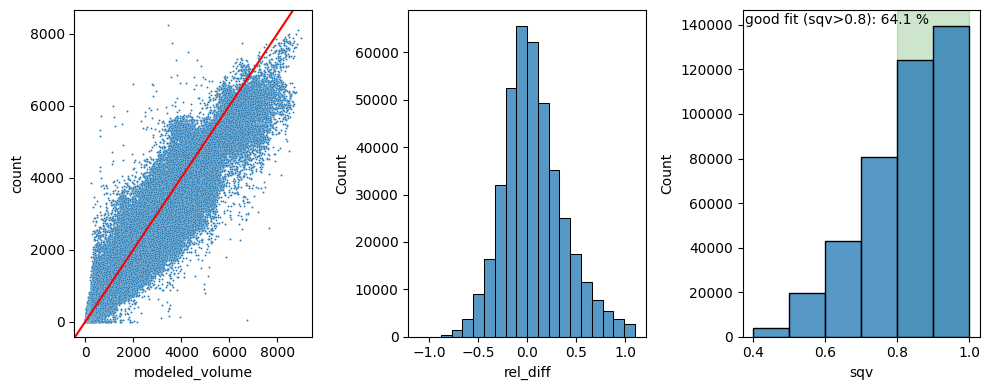

In [9]:
fig, ax = plt.subplots(1,3, figsize = (10,4), tight_layout = True)

mean_diff = all_data['rel_diff'].mean()
std_diff = all_data['rel_diff'].std()

sns.scatterplot(ax = ax[0], x = all_data['modeled_volume'], y = all_data['count'], s= 2)
sns.histplot(ax = ax[1], x = all_data['rel_diff'], binrange=(-1.1, 1.1), bins = 20)
sns.histplot(ax = ax[2], x = all_data['sqv'], binrange=(0.4,1), bins = 6)

text = f'good fit (sqv>0.8): {(len(all_data[all_data["sqv"]>=0.8]) / len(all_data))*100:.1f} % '
ax[2].text(.01, .99, text, ha='left', va='top', transform=ax[2].transAxes)
ax[2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[0].axline([0,0], [1,1], color = 'red')

# Plot Daily Values

In [10]:
daily_count = all_data.groupby('road_link_id').resample('1d')[['count', 'modeled_volume']].sum().reset_index(level=0)
daily_count.drop(daily_count[daily_count['count'] == 0].index, inplace = True)
daily_count['diff'] = daily_count['modeled_volume'] - daily_count['count']
daily_count['rel_diff'] = daily_count['diff'] / daily_count['count']
daily_count['sqv'] = daily_count.apply(lambda x: calc_sqv(x['count'],
                                                    x['modeled_volume'], f= 10000),
                                 axis = 1)

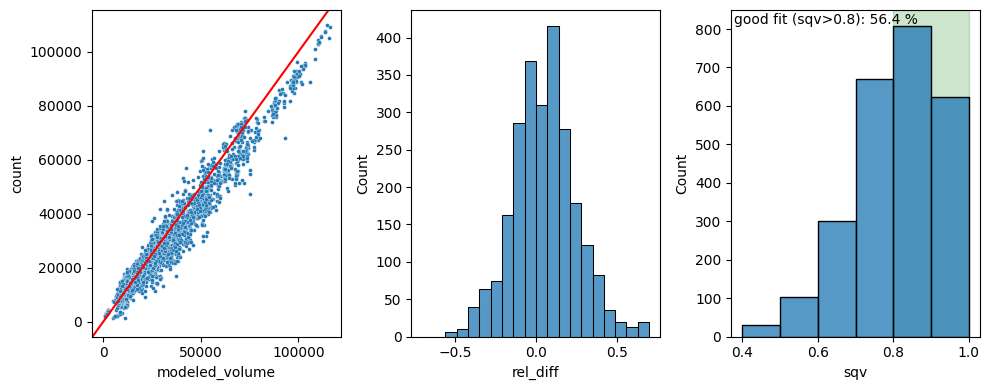

In [11]:
fig, ax = plt.subplots(1,3, figsize = (10,4), tight_layout = True)

mean_diff = all_data['rel_diff'].mean()
std_diff = all_data['rel_diff'].std()

sns.scatterplot(ax = ax[0], x = daily_count['modeled_volume'], y = daily_count['count'], s= 8)
sns.histplot(ax = ax[1], x = daily_count['rel_diff'], binrange=(-0.7, 0.7), bins = 20)
sns.histplot(ax = ax[2], x = daily_count['sqv'], binrange=(0.4,1), bins = 6)

text = f'good fit (sqv>0.8): {(len(daily_count[daily_count["sqv"]>=0.8]) / len(daily_count))*100:.1f} % '
ax[2].text(.01, .99, text, ha='left', va='top', transform=ax[2].transAxes)
ax[2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[0].axline([0,0], [1,1], color = 'red')

# Plot annual values

In [12]:
monthly_count = all_data.groupby('road_link_id').resample('1y')[['count', 'modeled_volume']].sum().reset_index(level=0)
monthly_count.drop(monthly_count[monthly_count['count'] == 0].index, inplace = True)
monthly_count['diff'] = monthly_count['modeled_volume'] - monthly_count['count']
monthly_count['rel_diff'] = monthly_count['diff'] / monthly_count['count']

Text(0.5, 0, 'Relative Difference')

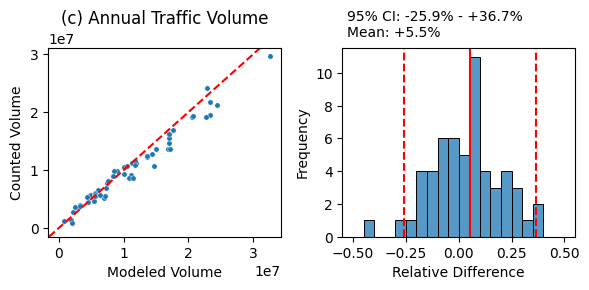

In [13]:
fig, ax = plt.subplots(1,2, figsize = (6,3), tight_layout = True)
ax[0].axline([0,0], [1,1], color = 'red',  linestyle = '--')
sns.scatterplot(ax = ax[0], x = monthly_count['modeled_volume'], y = monthly_count['count'], s= 15)
sns.histplot(ax = ax[1], x = monthly_count['rel_diff'], binrange=(-0.5, 0.5), bins = 20)

lb = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.975)
avg = np.mean(monthly_count["rel_diff"].to_numpy())

ax[1].axvline(lb, color = 'r', linestyle = '--')
ax[1].axvline(ub, color = 'r', linestyle = '--')
ax[1].axvline(avg, color = 'r')

text = f'95% CI: {lb*100:.1f}% - +{ub*100:.1f}% \nMean: +{avg*100:.1f}%'
ax[1].text(.02, 1.2, text, ha='left', va='top', transform=ax[1].transAxes)

ax[0].set_title('(c) Annual Traffic Volume')
ax[0].set_xlabel('Modeled Volume')
ax[0].set_ylabel('Counted Volume')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Relative Difference')

## Plot for paper

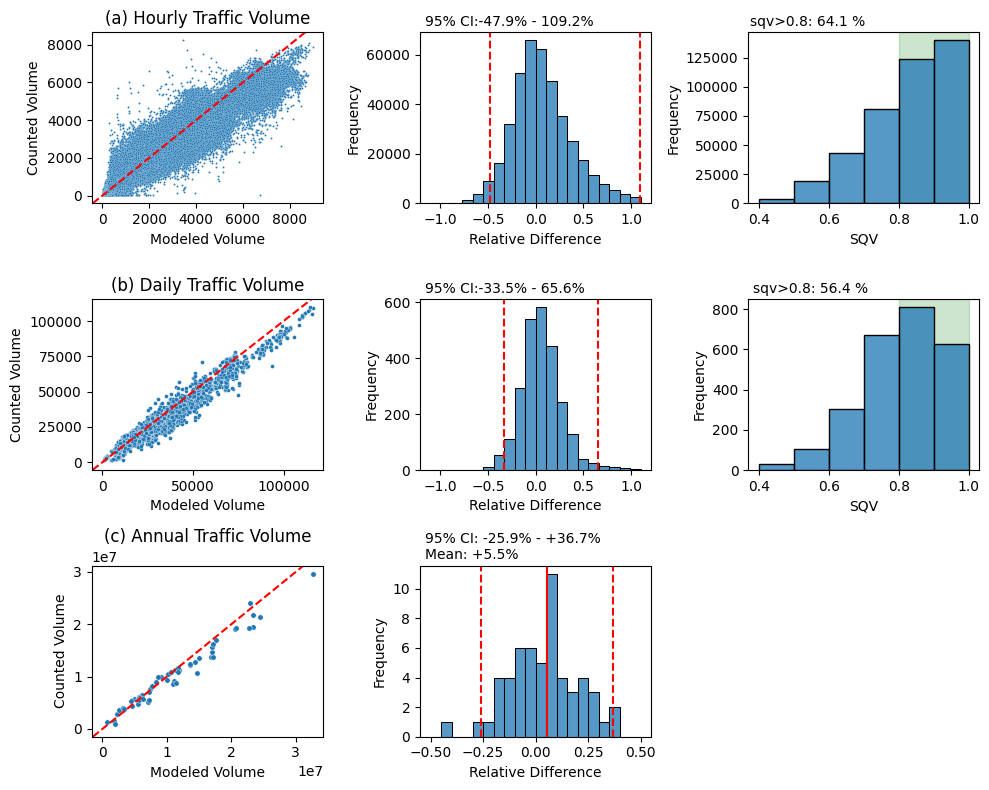

In [14]:
fig, ax = plt.subplots(3,3, figsize = (10,8), tight_layout = True)

ax[2,2].axis('off')

sns.scatterplot(ax = ax[0,0], x = all_data['modeled_volume'], y = all_data['count'], s= 2)
sns.histplot(ax = ax[0,1], x = all_data['rel_diff'], binrange=(-1.1, 1.1), bins = 20)
sns.histplot(ax = ax[0,2], x = all_data['sqv'], binrange=(0.4,1), bins = 6)

lb = np.quantile(all_data["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(all_data["rel_diff"].to_numpy(), 0.975)
ax[0,1].axvline(lb, color = 'r', linestyle = '--')
ax[0,1].axvline(ub, color = 'r', linestyle = '--')
text = f'95% CI:{lb*100:.1f}% - {ub*100:.1f}%'
ax[0,1].text(.02, 1.1, text, ha='left', va='top', transform=ax[0,1].transAxes)

text = f'sqv>0.8: {(len(all_data[all_data["sqv"]>=0.8]) / len(all_data))*100:.1f} % '
ax[0,2].text(.01, 1.1, text, ha='left', va='top', transform=ax[0,2].transAxes)
ax[0,2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[0,0].axline([0,0], [1,1], color = 'red', linestyle = '--')

ax[0,0].set_title('(a) Hourly Traffic Volume')
ax[0,0].set_xlabel('Modeled Volume')
ax[0,0].set_ylabel('Counted Volume')
ax[0,1].set_ylabel('Frequency')
ax[0,2].set_ylabel('Frequency')
ax[0,2].set_xlabel('SQV')
ax[0,1].set_xlabel('Relative Difference')

sns.scatterplot(ax = ax[1,0], x = daily_count['modeled_volume'], y = daily_count['count'], s= 8)
sns.histplot(ax = ax[1,1], x = daily_count['rel_diff'], binrange=(-1.1, 1.1), bins = 20)
sns.histplot(ax = ax[1,2], x = daily_count['sqv'], binrange=(0.4,1), bins = 6)

lb = np.quantile(daily_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(daily_count["rel_diff"].to_numpy(), 0.975)
ax[1,1].axvline(lb, color = 'r', linestyle = '--')
ax[1,1].axvline(ub, color = 'r', linestyle = '--')
text = f'95% CI:{lb*100:.1f}% - {ub*100:.1f}%'
ax[1,1].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,1].transAxes)

text = f'sqv>0.8: {(len(daily_count[daily_count["sqv"]>=0.8]) / len(daily_count))*100:.1f} % '
ax[1,2].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,2].transAxes)
ax[1,2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[1,0].axline([0,0], [1,1], color = 'red', linestyle = '--')

ax[1,0].set_title('(b) Daily Traffic Volume')
ax[1,0].set_xlabel('Modeled Volume')
ax[1,0].set_ylabel('Counted Volume')
ax[1,1].set_ylabel('Frequency')
ax[1,2].set_ylabel('Frequency')
ax[1,2].set_xlabel('SQV')
ax[1,1].set_xlabel('Relative Difference')


# add annual estimates to the plot

ax[2,0].axline([0,0], [1,1], color = 'red',  linestyle = '--')
sns.scatterplot(ax = ax[2,0], x = monthly_count['modeled_volume'], y = monthly_count['count'], s= 15)
sns.histplot(ax = ax[2,1], x = monthly_count['rel_diff'], binrange=(-0.5, 0.5), bins = 20)

lb = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.975)
avg = np.mean(monthly_count["rel_diff"].to_numpy())

ax[2,1].axvline(lb, color = 'r', linestyle = '--')
ax[2,1].axvline(ub, color = 'r', linestyle = '--')
ax[2,1].axvline(avg, color = 'r')

text = f'95% CI: {lb*100:.1f}% - +{ub*100:.1f}% \nMean: +{avg*100:.1f}%'
ax[2,1].text(.02, 1.2, text, ha='left', va='top', transform=ax[2,1].transAxes)

ax[2,0].set_title('(c) Annual Traffic Volume')
ax[2,0].set_xlabel('Modeled Volume')
ax[2,0].set_ylabel('Counted Volume')
ax[2,1].set_ylabel('Frequency')
ax[2,1].set_xlabel('Relative Difference')
plt.show()
